# SDM

In [92]:
# Load the required packages
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit = 4.0)

In [93]:
# Get the polygon of interest
place = SpeciesDistributionToolkit.gadm("PRY")
extent = SpeciesDistributionToolkit.boundingbox(place)

(left = -62.642398834228516, right = -54.25859832763672, bottom = -27.60569953918457, top = -19.29520034790039)

In [94]:
# Give the source of raster data
provider = RasterData(CHELSA2, BioClim)

RasterData{CHELSA2, BioClim}(CHELSA2, BioClim)

In [95]:
# Download the layers
L = SDMLayer{Float16}[SDMLayer(provider; layer=l, extent...) for l in layers(provider)]

19-element Vector{SDMLayer{Float16}}:
 SDMLayer{Float16}(Float16[2.948e3 2.948e3 … 2.936e3 2.938e3; 2.948e3 2.948e3 … 2.936e3 2.936e3; … ; 2.976e3 2.976e3 … 2.982e3 2.98e3; 2.976e3 2.976e3 … 2.984e3 2.98e3], Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[101.0 101.0 … 92.0 92.0; 101.0 101.0 … 92.0 92.0; … ; 96.0 96.0 … 98.0 98.0; 96.0 96.0 … 98.0 98.0], Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[4.54 4.53 … 4.74 4.7; 4.53 4.54 … 4.77 4.76; … ; 5.73 5.75 … 6.36 6.37; 5.76 5.76 … 6.36 6.37], Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLay

In [96]:
# Clip the rasters to the polygon
mask!(L, place)

19-element Vector{SDMLayer{Float16}}:
 SDMLayer{Float16}(Float16[2.948e3 2.948e3 … 2.936e3 2.938e3; 2.948e3 2.948e3 … 2.936e3 2.936e3; … ; 2.976e3 2.976e3 … 2.982e3 2.98e3; 2.976e3 2.976e3 … 2.984e3 2.98e3], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[101.0 101.0 … 92.0 92.0; 101.0 101.0 … 92.0 92.0; … ; 96.0 96.0 … 98.0 98.0; 96.0 96.0 … 98.0 98.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[4.54 4.53 … 4.74 4.7; 4.53 4.54 … 4.77 4.76; … ; 5.73 5.75 … 6.36 6.37; 5.76 5.76 … 6.36 6.37], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.65013935825001, -54.25847272515001), (-27.60847247174999, -19.291805838349994), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLay

In [97]:
# Get occurrence data from GBIF
tx = taxon("Akodon montensis")
presences = occurrences(tx, first(L), "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 300, "hasCoordinate" => true)
occurrences!(presences)
@info "Retrieved $(count(presences)) occurrences"

┌ Info: Retrieved 562 occurrences
└ @ Main /home/tpoisot/Documents/ms_sdt_software/appendix/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:5


In [185]:
# Pseudo-absence generation
presencelayer = mask(first(L), presences)
background = pseudoabsencemask(DistanceToEvent, presencelayer)
bgpoints = backgroundpoints(nodata(background, d -> d < 3), 8sum(presencelayer))

SDM Layer with 506331 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

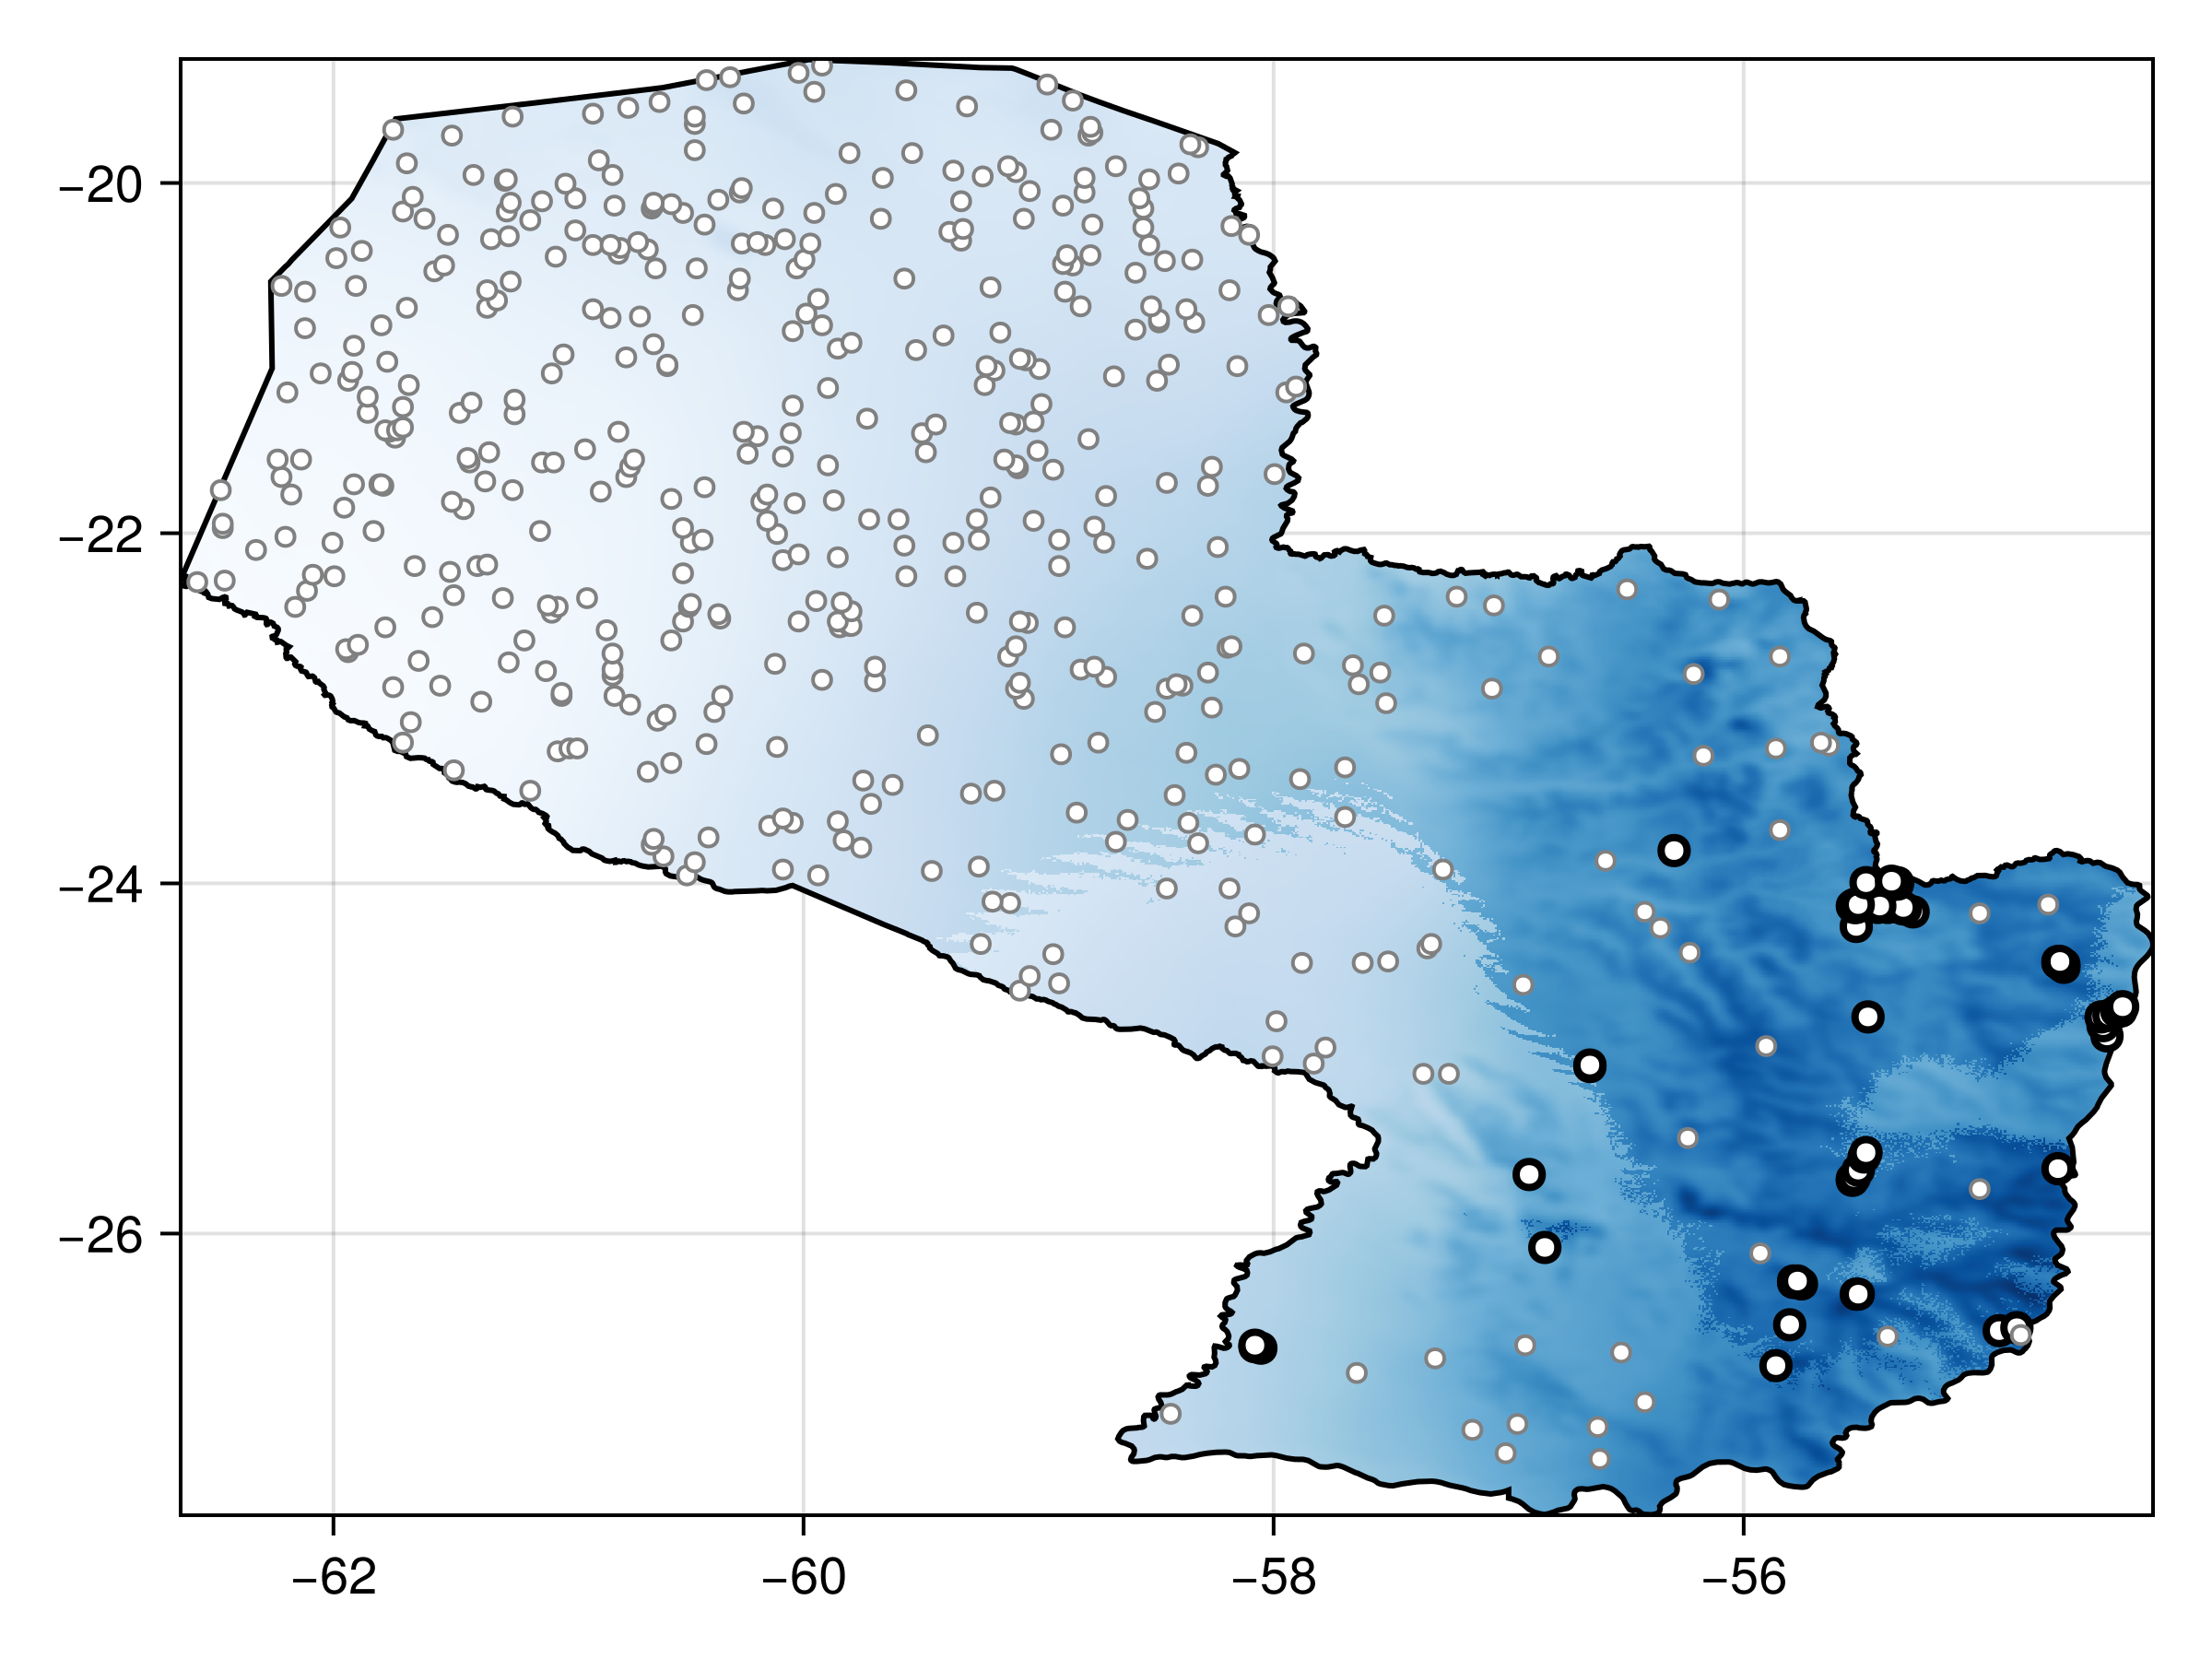

In [186]:
# Illustration
heatmap(L[end], colormap=:Blues)
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [187]:
# Specification of the SDM
sdm = SDM(PCATransform, DecisionTree, L, presencelayer, bgpoints)

PCATransform → DecisionTree → P(x) ≥ 0.5

In [188]:
# Cross-validation
folds = kfold(sdm);
cv = crossvalidate(sdm, folds; threshold = true);
mean(mcc.(cv.validation))

0.7511157230896705

In [189]:
# Variable selection and cross-validation
reset!(sdm)
backwardselection!(sdm, folds)
cv2 = crossvalidate(sdm, folds; threshold = true);
mean(mcc.(cv2.validation))

0.8801023696418842

In [190]:
# Inspection of selected variables
variables(sdm)

16-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 13
 15
 17
 18
 19

In [191]:
# Final re-training
train!(sdm)

PCATransform → DecisionTree → P(x) ≥ 0.403

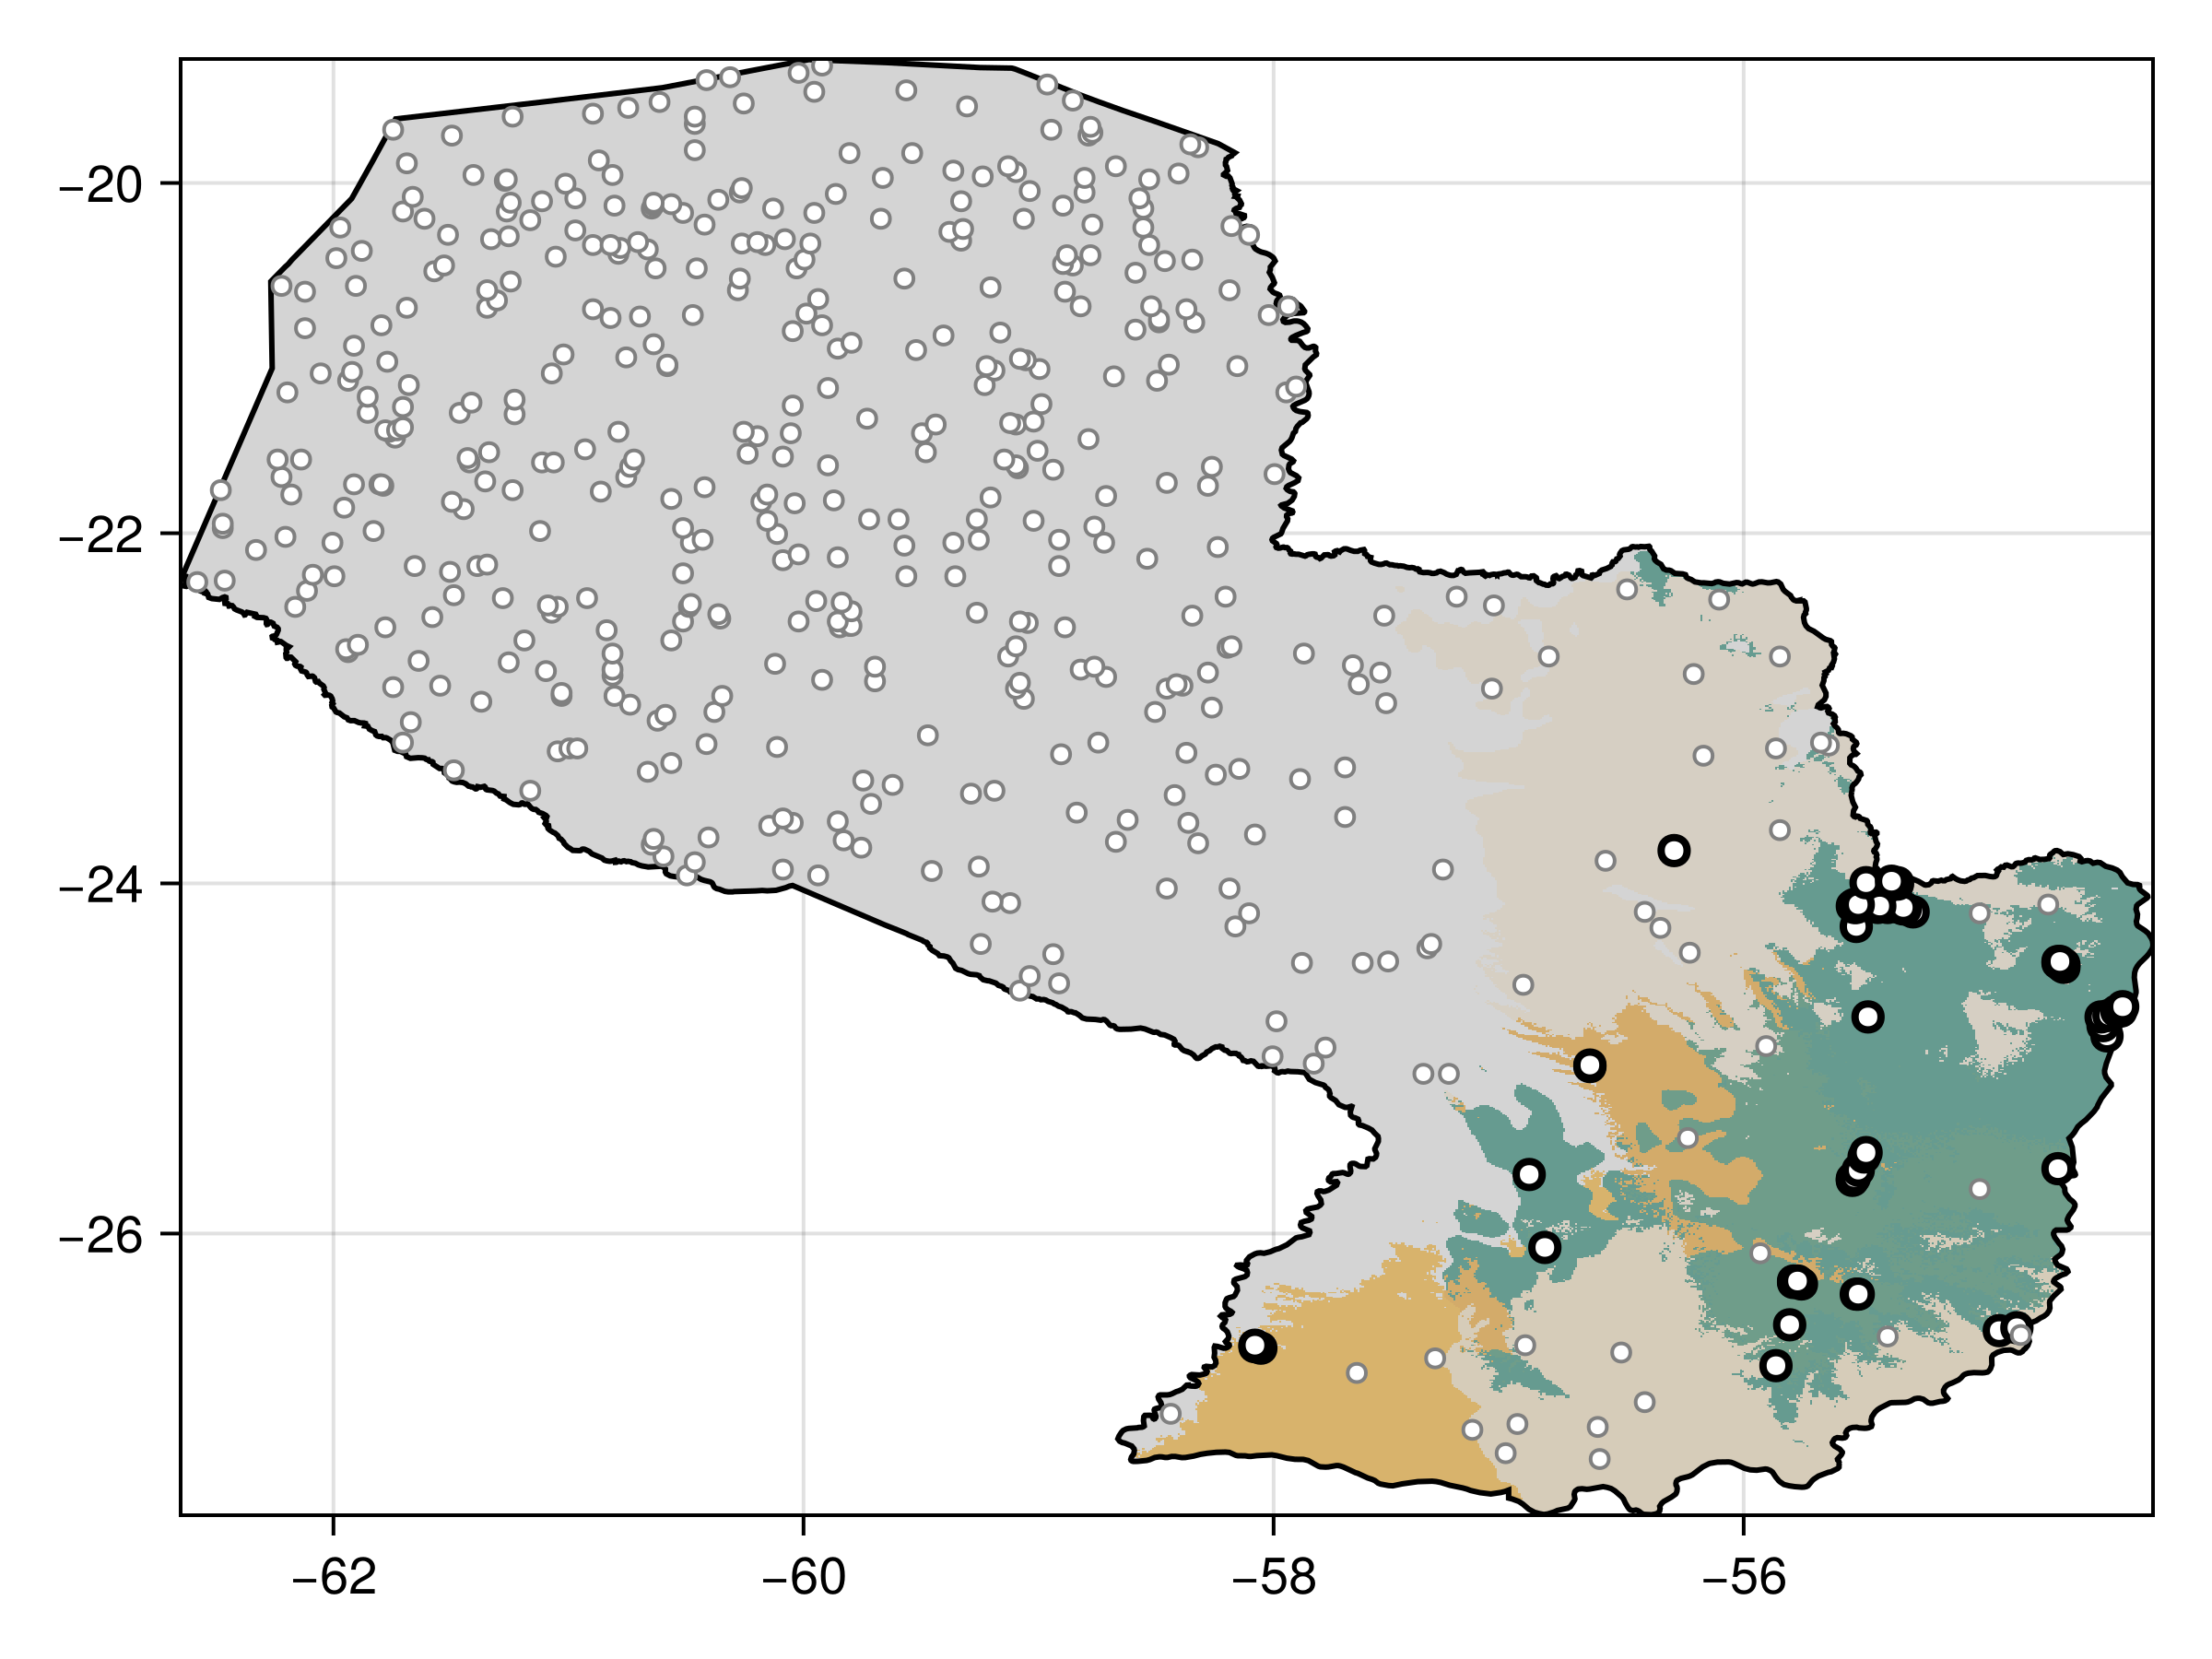

In [192]:
# Initial prediction (decision tree)
heatmap(predict(sdm, L; threshold=false), colormap=Reverse(:linear_gow_60_85_c27_n256))
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [193]:
# Setting up the ensemble
ensemble = Bagging(sdm, 31)
bagfeatures!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.403} × 31

In [194]:
# Training of the ensemble
train!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.403} × 31

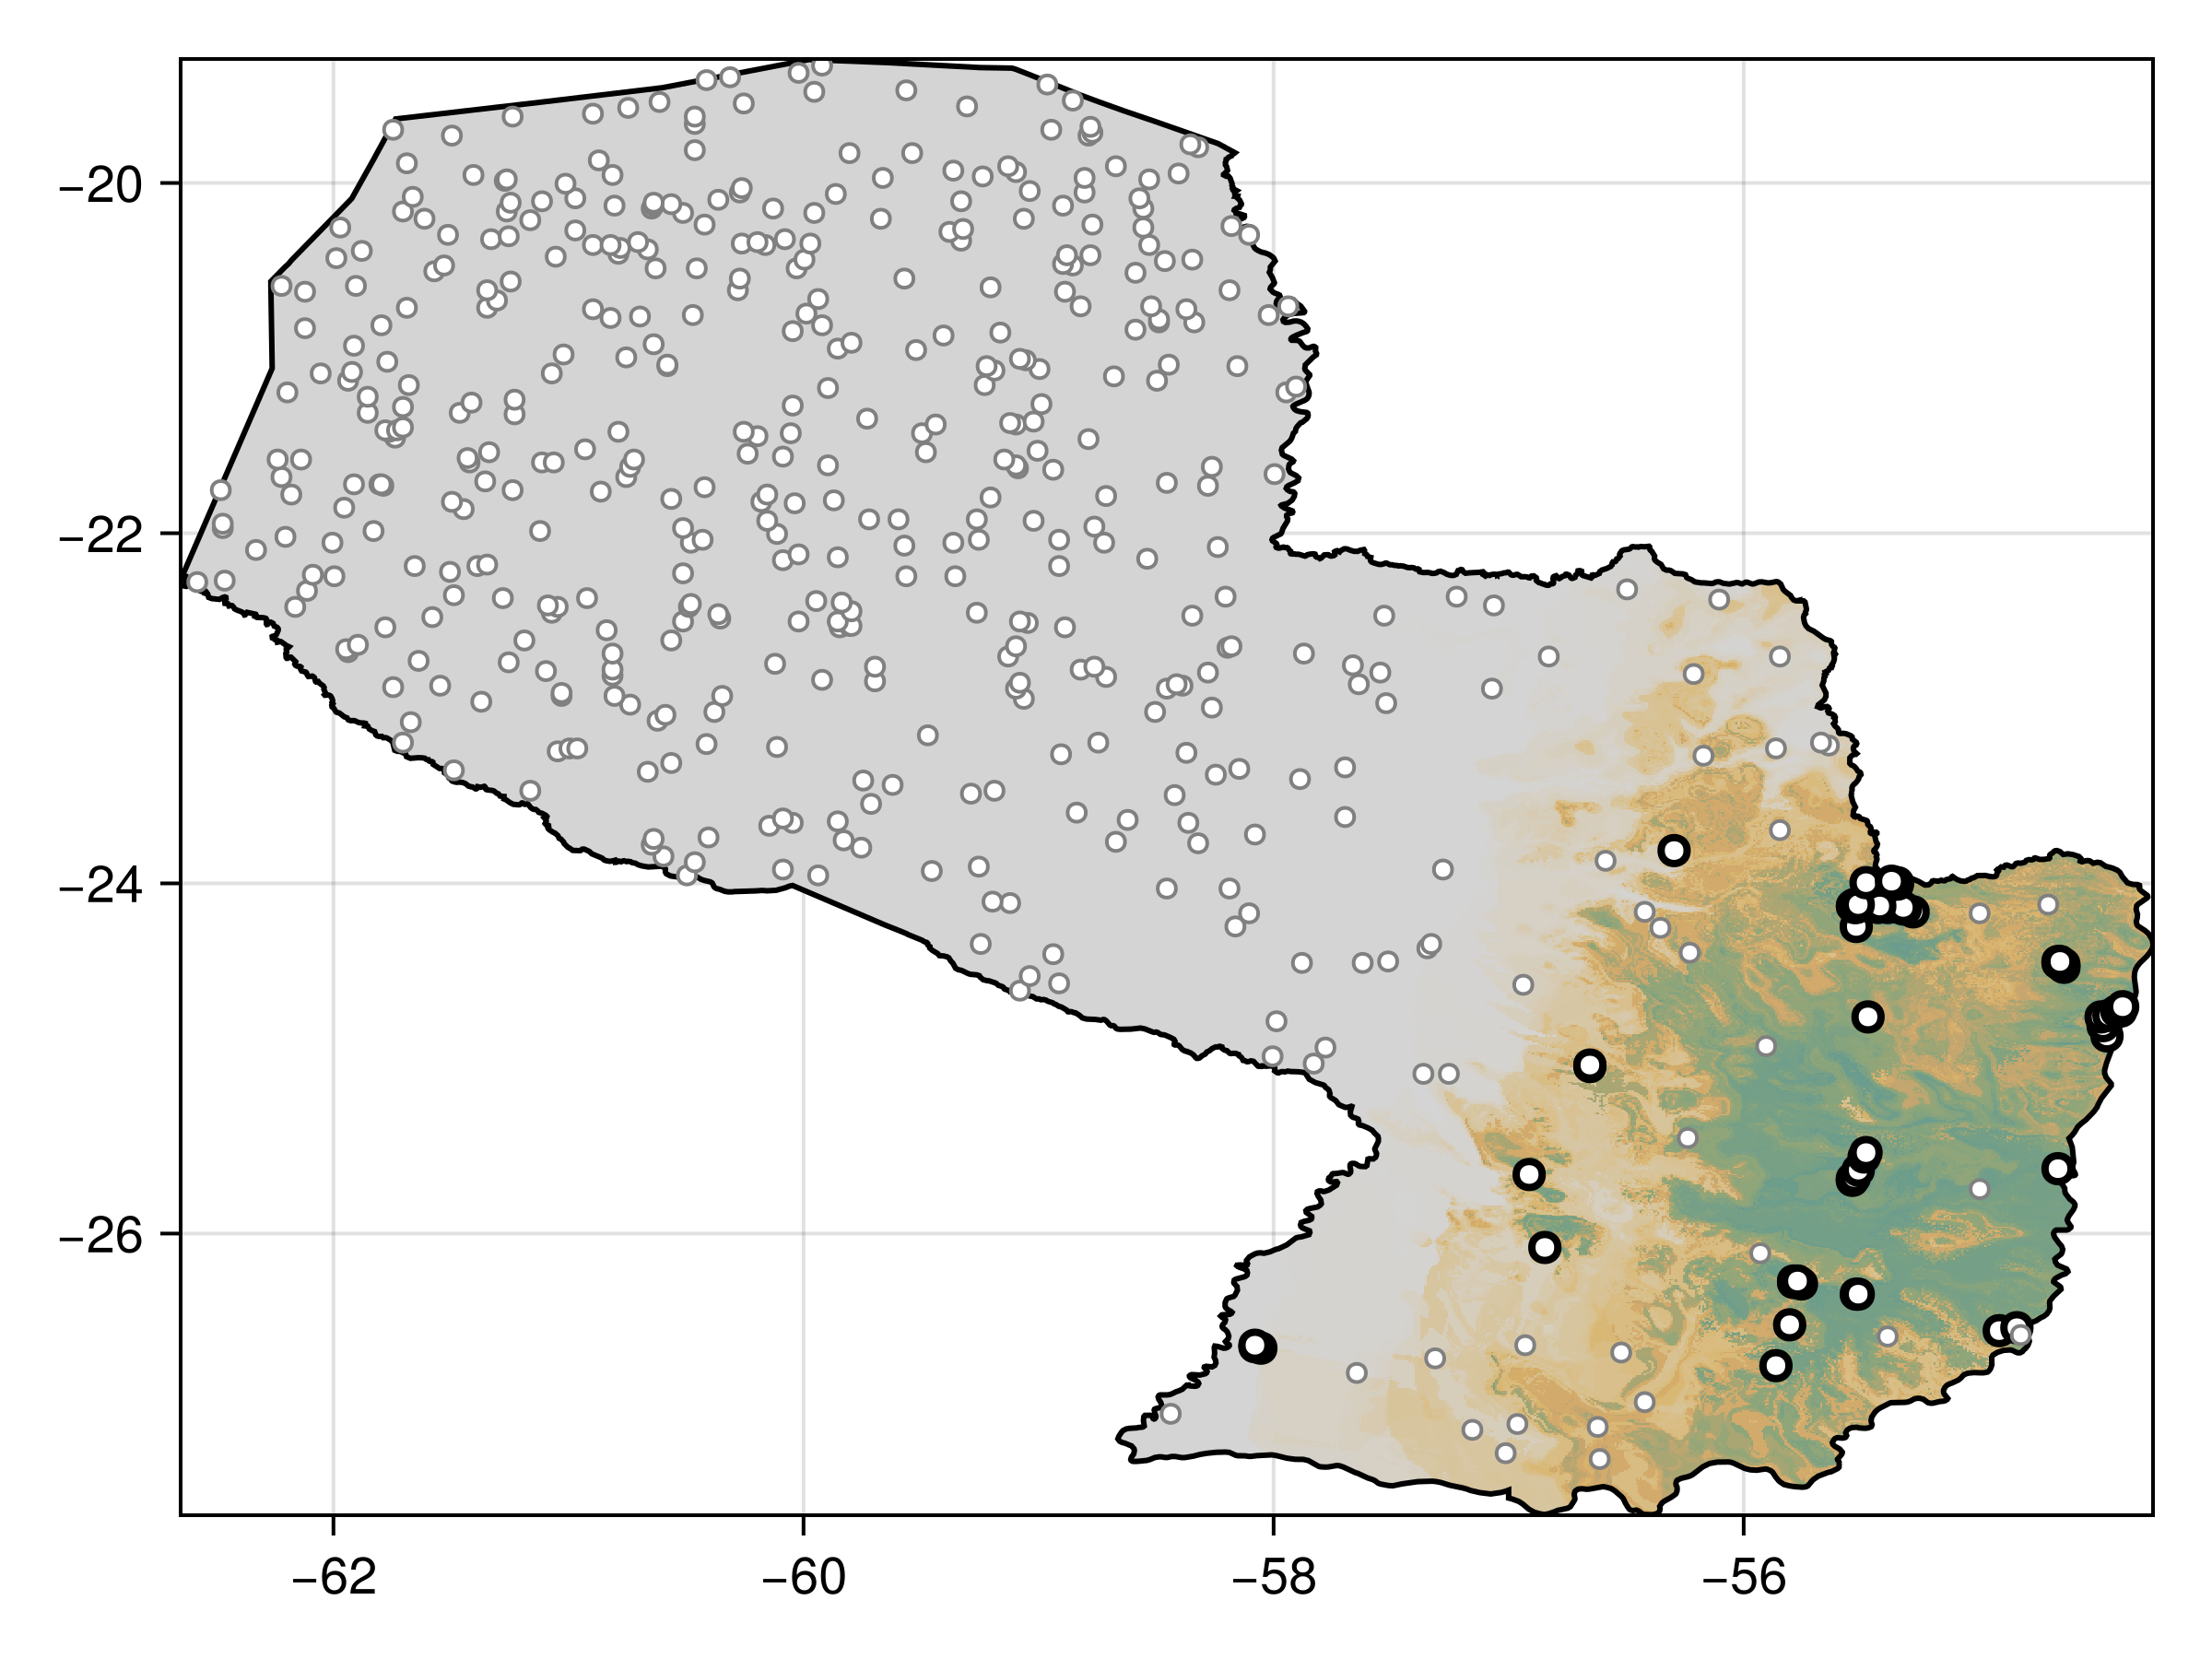

In [195]:
# Predictions of the ensemble
uncertainty = predict(ensemble, L; threshold=false)
heatmap(uncertainty, colormap=Reverse(:linear_gow_60_85_c27_n256))
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [196]:
# Get the elevation data
elevprov = RasterData(WorldClim2, Elevation)
elev = convert(SDMLayer{Float16}, SDMLayer(elevprov; resolution=0.5, extent...))

SDM Layer with 1004986 Float16 cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

In [197]:
# Project the elevation data
elevation = similar(L[1], Float16)
SimpleSDMLayers.interpolate!(elevation, elev)

SDM Layer with 1002986 Float16 cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

In [198]:
# Get the elevation range
elevation_range = extrema(elevation[presences])

(Float16(60.0), Float16(458.5))

In [199]:
# Calculate final range (climate and elevation)
in_range = predict(ensemble, L; threshold=true, consensus=majority)
in_elev = (e -> (elevation_range[1] <= e <= elevation_range[2])).(elevation)

SDM Layer with 1002986 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

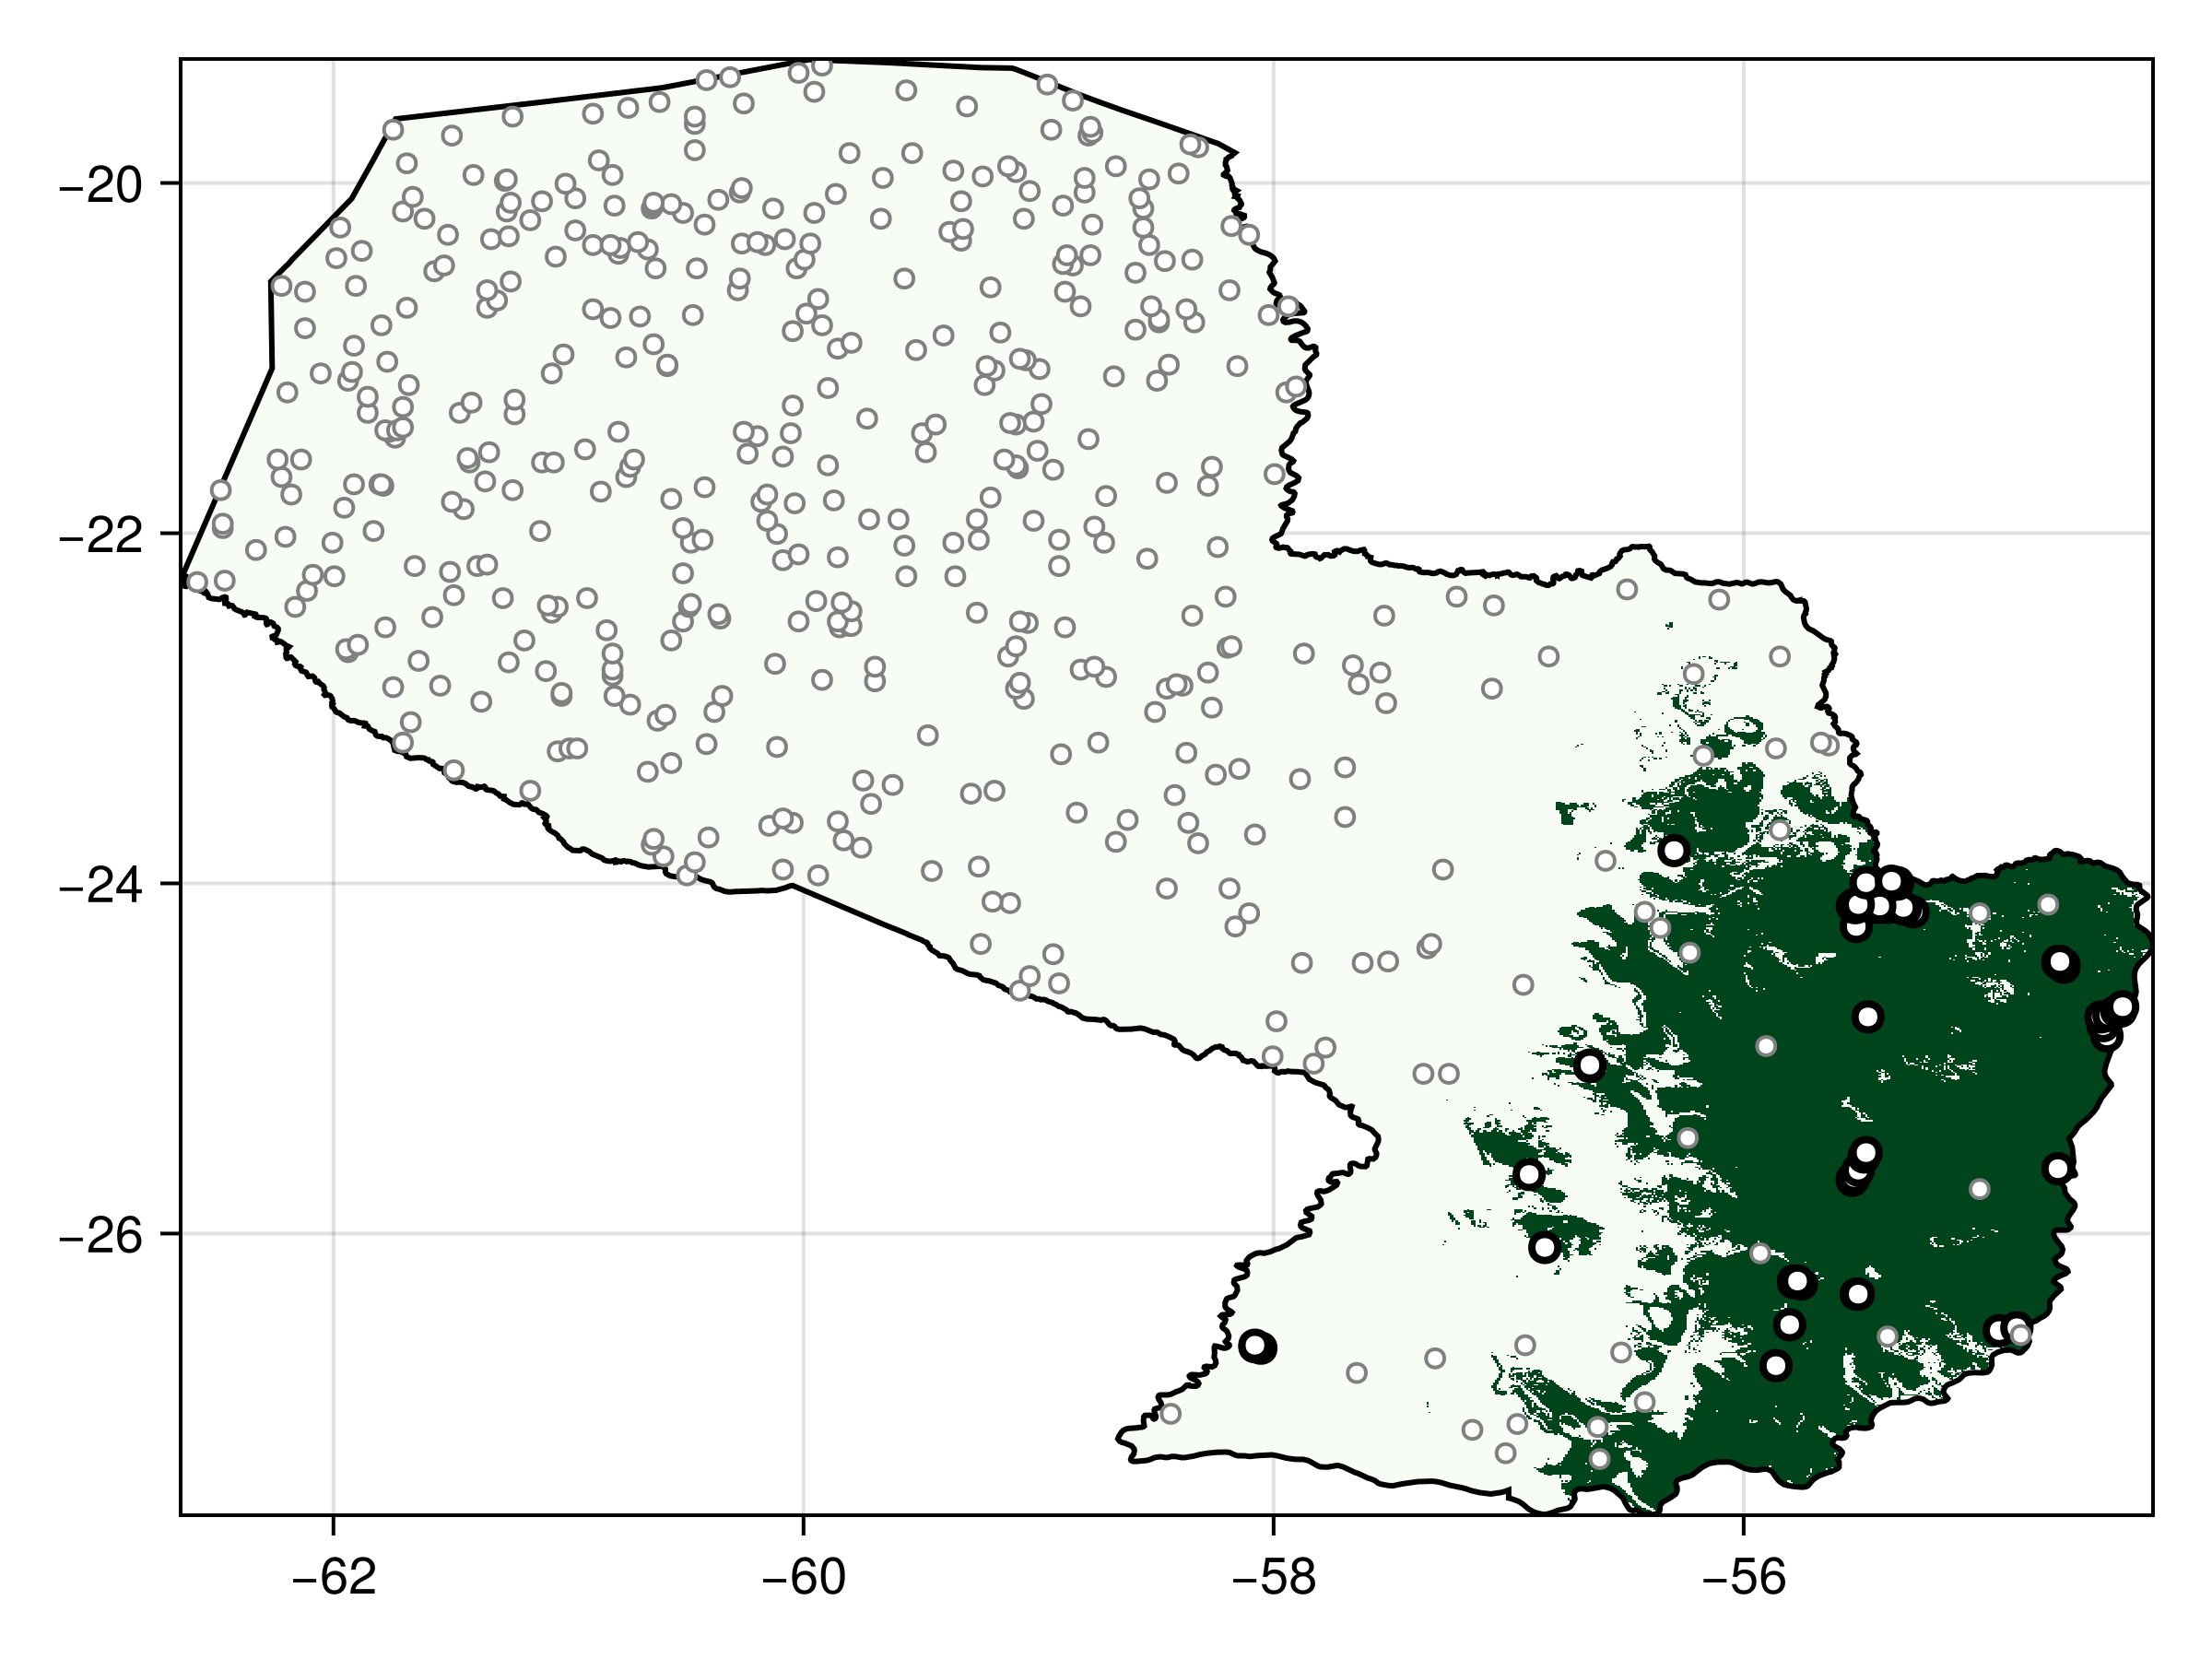

In [200]:
#| label: fig-sdm-output
#| fig-cap: "also yeah"
heatmap(in_range .& in_elev, colormap=:Greens)
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()